In [29]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import langevin
import lmfit as lm
from lmfit.models import ExponentialModel
from scipy.stats import pearsonr

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 35010732 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [30]:
# function to calculate A and B from the dataset
def OUanalytic(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/A**2/2
    Btmp = B**2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B**4*(N-1))*datasq - 2*B*(1+B**2+2*N)*datacorr
    P2B = -tmp/((1-B**2)**2*(data1sq+dataNsq + (1+B**2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult(data,deltat):
    A, dA, B ,dB = OUanalytic(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [31]:
A,D = 1.0,1.0
delta_t=0.01
M=1000 # number of data sets
N=2000 # length of data set
P=500 # range to fit acf

In [32]:
# let us first calculate the standard deviation for each point of the acf
# all acfs are stored in acf_all for later analysis

acf_all = None
result_Bayes_array = None
for i in range(M):
    data = langevin.time_series(A=A, D=D, delta_t=delta_t, N=N)
    
    results = OUresult(data,delta_t)
    if result_Bayes_array is None:
        result_Bayes_array = results
    else:
        result_Bayes_array = np.vstack((result_Bayes_array, results))

    # calculate autocorrelation function
    f = np.fft.rfft(data)
    acf = np.fft.irfft(f * np.conjugate(f))
    acf = np.fft.fftshift(acf) / N
    autocorr = acf[int(N / 2):]

    y = autocorr[:min(int(N / 2), P)]
    t = np.arange(min(int(N / 2), P))

    if acf_all is None:
        acf_all = y
    else:
        acf_all = np.vstack((acf_all, y))
        
acf_std = np.std(acf_all, axis=0)
acf_mean = np.mean(acf_all, axis=0)

<ErrorbarContainer object of 3 artists>

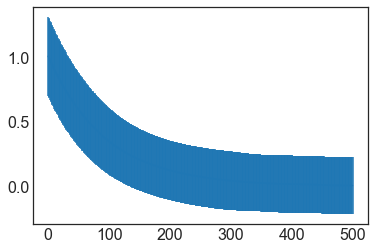

In [33]:
plt.errorbar(t,acf_mean,yerr=acf_std)

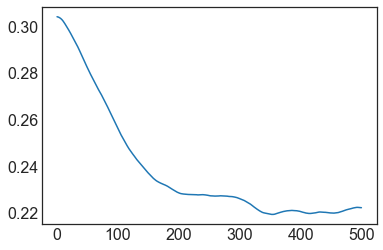

In [34]:
plt.plot(t,acf_std)

In [35]:
acf_all[0].size

500

In [36]:
mod = ExponentialModel()
result_array = None
for i,y in enumerate(acf_all):
    print("***** Iteration ",i," *****")
    pars = mod.make_params()
    pars['decay'].set(value=100,min=0,vary=True)
    pars['amplitude'].set(value=1,min=0,vary=True)
    try:
        out = mod.fit(y, pars, x=t)
    except:
        fit_results = None
        print('fit did not work')
    else:
        fit_results = np.array([out.values['decay']*delta_t,
                            out.covar[0,0],
                            out.values['amplitude'],
                            out.covar[1,1],
                            out.covar[0,1]])
        print(out.fit_report(min_correl=0.25))
        

    if result_array is None:
        result_array = fit_results
    else:
        result_array = np.vstack((result_array, fit_results))


***** Iteration  0  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 4.64439350
    reduced chi-square = 0.00932609
    Akaike info crit   = -2335.47365
    Bayesian info crit = -2327.04444
[[Variables]]
    decay:      36.9407220 +/- 1.91738410 (5.19%) (init = 100)
    amplitude:  0.85429037 +/- 0.03093783 (3.62%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.697

***** Iteration  1  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 44
    # data points      = 500
    # variables        = 2
    chi-square         = 8.75045310
    reduced chi-square = 0.01757119
    Akaike info crit   = -2018.75131
    Bayesian info crit = -2010.32209
[[Variables]]
    decay:      66.7927185 +/- 2.27822878 (3.41%) (init = 100)
    amplitude:

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 9.72456053
    reduced chi-square = 0.01952723
    Akaike info crit   = -1965.97670
    Bayesian info crit = -1957.54748
[[Variables]]
    decay:      55.2467315 +/- 2.35539681 (4.26%) (init = 100)
    amplitude:  1.23640328 +/- 0.03692689 (2.99%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.701

***** Iteration  54  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 2.25927132
    reduced chi-square = 0.00453669
    Akaike info crit   = -2695.78288
    Bayesian info crit = -2687.35366
[[Variables]]
    decay:      70.4739065 +/- 2.10102904 (2.98%) (init = 100)
    amplitude:  0.75582954 +/- 0.015822

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 49
    # data points      = 500
    # variables        = 2
    chi-square         = 2.15857409
    reduced chi-square = 0.00433449
    Akaike info crit   = -2718.58012
    Bayesian info crit = -2710.15090
[[Variables]]
    decay:      42.3923268 +/- 2.46376512 (5.81%) (init = 100)
    amplitude:  0.48655010 +/- 0.01975358 (4.06%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.699

***** Iteration  108  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 2.36003699
    reduced chi-square = 0.00473903
    Akaike info crit   = -2673.96540
    Bayesian info crit = -2665.53619
[[Variables]]
    decay:      150.169592 +/- 4.45609852 (2.97%) (init = 100)
    amplitude:  0.54987295 +/- 0.01128

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.81370118
    reduced chi-square = 0.00163394
    Akaike info crit   = -3206.38509
    Bayesian info crit = -3197.95587
[[Variables]]
    decay:      148.097131 +/- 1.05438777 (0.71%) (init = 100)
    amplitude:  1.35253494 +/- 0.00666709 (0.49%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.712

***** Iteration  165  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 70
    # data points      = 500
    # variables        = 2
    chi-square         = 1.98989703
    reduced chi-square = 0.00399578
    Akaike info crit   = -2759.26260
    Bayesian info crit = -2750.83339
[[Variables]]
    decay:      23.4366306 +/- 1.45791902 (6.22%) (init = 100)
    amplitude:  0.58164151 +/- 0.02503

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 3.22751214
    reduced chi-square = 0.00648095
    Akaike info crit   = -2517.44825
    Bayesian info crit = -2509.01903
[[Variables]]
    decay:      133.919397 +/- 2.17614077 (1.62%) (init = 100)
    amplitude:  1.22649181 +/- 0.01389605 (1.13%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.709

***** Iteration  222  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 4.92912687
    reduced chi-square = 0.00989785
    Akaike info crit   = -2305.72312
    Bayesian info crit = -2297.29390
[[Variables]]
    decay:      226.808367 +/- 4.27385648 (1.88%) (init = 100)
    amplitude:  1.14362054 +/- 0.01381


***** Iteration  276  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 42
    # data points      = 500
    # variables        = 2
    chi-square         = 20.7628800
    reduced chi-square = 0.04169253
    Akaike info crit   = -1586.72066
    Bayesian info crit = -1578.29144
[[Variables]]
    decay:      66.0988438 +/- 3.72155835 (5.63%) (init = 100)
    amplitude:  1.25192484 +/- 0.04948689 (3.95%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.702

***** Iteration  277  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 3.21043898
    reduced chi-square = 0.00644666
    Akaike info crit   = -2520.10021
    Bayesian info crit = -2511.67099
[[Variables]]
    decay:      75.2024271 +/- 2.11115339 (2.81%) (init = 100)
    ampli

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 44
    # data points      = 500
    # variables        = 2
    chi-square         = 43.1730432
    reduced chi-square = 0.08669286
    Akaike info crit   = -1220.69590
    Bayesian info crit = -1212.26668
[[Variables]]
    decay:      141.867796 +/- 3.88280001 (2.74%) (init = 100)
    amplitude:  2.60405991 +/- 0.04950496 (1.90%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.710

***** Iteration  330  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 38
    # data points      = 500
    # variables        = 2
    chi-square         = 10.8314750
    reduced chi-square = 0.02174995
    Akaike info crit   = -1912.07592
    Bayesian info crit = -1903.64671
[[Variables]]
    decay:      69.1064030 +/- 3.01664587 (4.37%) (init = 100)
    amplitude:  1.14153178 +/- 0.03497

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 500
    # variables        = 2
    chi-square         = 5.52472984
    reduced chi-square = 0.01109384
    Akaike info crit   = -2248.68687
    Bayesian info crit = -2240.25766
[[Variables]]
    decay:      152.078467 +/- 4.64821008 (3.06%) (init = 100)
    amplitude:  0.81321224 +/- 0.01717036 (2.11%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.712

***** Iteration  383  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 9.03376143
    reduced chi-square = 0.01814008
    Akaike info crit   = -2002.81963
    Bayesian info crit = -1994.39042
[[Variables]]
    decay:      274.392463 +/- 9.24639462 (3.37%) (init = 100)
    amplitude:  0.86680759 +/- 0.01753

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 6.24038203
    reduced chi-square = 0.01253089
    Akaike info crit   = -2187.78335
    Bayesian info crit = -2179.35413
[[Variables]]
    decay:      285.897814 +/- 9.95677247 (3.48%) (init = 100)
    amplitude:  0.69978593 +/- 0.01439072 (2.06%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.752

***** Iteration  439  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 1.08108115
    reduced chi-square = 0.00217085
    Akaike info crit   = -3064.32325
    Bayesian info crit = -3055.89403
[[Variables]]
    decay:      110.265761 +/- 1.33520280 (1.21%) (init = 100)
    amplitude:  1.03670521 +/- 0.00881

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 5.89179109
    reduced chi-square = 0.01183091
    Akaike info crit   = -2216.52403
    Bayesian info crit = -2208.09481
[[Variables]]
    decay:      180.213836 +/- 4.19952813 (2.33%) (init = 100)
    amplitude:  1.04787216 +/- 0.01649777 (1.57%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.720

***** Iteration  497  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 49
    # data points      = 500
    # variables        = 2
    chi-square         = 3.86006136
    reduced chi-square = 0.00775113
    Akaike info crit   = -2427.96251
    Bayesian info crit = -2419.53329
[[Variables]]
    decay:      33.2154661 +/- 1.91156303 (5.76%) (init = 100)
    amplitude:  0.73949628 +/- 0.02965

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 2.98930836
    reduced chi-square = 0.00600263
    Akaike info crit   = -2555.78303
    Bayesian info crit = -2547.35381
[[Variables]]
    decay:      185.034116 +/- 3.29973778 (1.78%) (init = 100)
    amplitude:  0.96937240 +/- 0.01162630 (1.20%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.721

***** Iteration  550  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 500
    # variables        = 2
    chi-square         = 10.8034409
    reduced chi-square = 0.02169366
    Akaike info crit   = -1913.37171
    Bayesian info crit = -1904.94249
[[Variables]]
    decay:      93.4438056 +/- 4.88286470 (5.23%) (init = 100)
    amplitude:  0.82163224 +/- 0.03016

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 3.38338692
    reduced chi-square = 0.00679395
    Akaike info crit   = -2493.86542
    Bayesian info crit = -2485.43620
[[Variables]]
    decay:      1368.18557 +/- 73.1316134 (5.35%) (init = 100)
    amplitude:  0.78606942 +/- 0.00803204 (1.02%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.839

***** Iteration  607  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.97676046
    reduced chi-square = 0.00196137
    Akaike info crit   = -3115.06097
    Bayesian info crit = -3106.63175
[[Variables]]
    decay:      212.534910 +/- 1.78064678 (0.84%) (init = 100)
    amplitude:  1.15200888 +/- 0.00629

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 39.8907408
    reduced chi-square = 0.08010189
    Akaike info crit   = -1260.23193
    Bayesian info crit = -1251.80271
[[Variables]]
    decay:      100.068280 +/- 6.06739670 (6.06%) (init = 100)
    amplitude:  1.31684126 +/- 0.05606708 (4.26%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.704

***** Iteration  663  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 60
    # data points      = 500
    # variables        = 2
    chi-square         = 19.4894101
    reduced chi-square = 0.03913536
    Akaike info crit   = -1618.36843
    Bayesian info crit = -1609.93921
[[Variables]]
    decay:      51.3457763 +/- 2.80348696 (5.46%) (init = 100)
    amplitude:  1.41668297 +/- 0.05415

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 4.75435008
    reduced chi-square = 0.00954689
    Akaike info crit   = -2323.77405
    Bayesian info crit = -2315.34483
[[Variables]]
    decay:      175.661566 +/- 3.23191806 (1.84%) (init = 100)
    amplitude:  1.19980596 +/- 0.01497671 (1.25%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.719

***** Iteration  719  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 3.31621483
    reduced chi-square = 0.00665907
    Akaike info crit   = -2503.89204
    Bayesian info crit = -2495.46282
[[Variables]]
    decay:      193.376737 +/- 3.09990976 (1.60%) (init = 100)
    amplitude:  1.12573373 +/- 0.01203


***** Iteration  771  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 1.02326319
    reduced chi-square = 0.00205475
    Akaike info crit   = -3091.80569
    Bayesian info crit = -3083.37647
[[Variables]]
    decay:      242.433796 +/- 4.58581492 (1.89%) (init = 100)
    amplitude:  0.51763230 +/- 0.00614872 (1.19%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.739

***** Iteration  772  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 56
    # data points      = 500
    # variables        = 2
    chi-square         = 26.1174812
    reduced chi-square = 0.05244474
    Akaike info crit   = -1472.00162
    Bayesian info crit = -1463.57240
[[Variables]]
    decay:      51.4720389 +/- 3.41746755 (6.64%) (init = 100)
    ampli

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 5.09215400
    reduced chi-square = 0.01022521
    Akaike info crit   = -2289.45359
    Bayesian info crit = -2281.02437
[[Variables]]
    decay:      113.379915 +/- 2.53820730 (2.24%) (init = 100)
    amplitude:  1.20147708 +/- 0.01887084 (1.57%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.706

***** Iteration  824  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 2.47469283
    reduced chi-square = 0.00496926
    Akaike info crit   = -2650.24591
    Bayesian info crit = -2641.81669
[[Variables]]
    decay:      134.953742 +/- 2.80251891 (2.08%) (init = 100)
    amplitude:  0.83764139 +/- 0.01212

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 7.17197613
    reduced chi-square = 0.01440156
    Akaike info crit   = -2118.21344
    Bayesian info crit = -2109.78422
[[Variables]]
    decay:      53.9389604 +/- 2.68691049 (4.98%) (init = 100)
    amplitude:  0.91954844 +/- 0.03208018 (3.49%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.701

***** Iteration  880  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 0.66471733
    reduced chi-square = 0.00133477
    Akaike info crit   = -3307.50075
    Bayesian info crit = -3299.07153
[[Variables]]
    decay:      39.7913375 +/- 1.05389493 (2.65%) (init = 100)
    amplitude:  0.61096574 +/- 0.01129

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 500
    # variables        = 2
    chi-square         = 15.3857639
    reduced chi-square = 0.03089511
    Akaike info crit   = -1736.58272
    Bayesian info crit = -1728.15350
[[Variables]]
    decay:      146.688163 +/- 3.63675465 (2.48%) (init = 100)
    amplitude:  1.69451820 +/- 0.02911611 (1.72%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.711

***** Iteration  936  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 2.53296686
    reduced chi-square = 0.00508628
    Akaike info crit   = -2638.60841
    Bayesian info crit = -2630.17919
[[Variables]]
    decay:      172.619962 +/- 2.43956274 (1.41%) (init = 100)
    amplitude:  1.14541636 +/- 0.01101

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 4.54841822
    reduced chi-square = 0.00913337
    Akaike info crit   = -2345.91428
    Bayesian info crit = -2337.48507
[[Variables]]
    decay:      108.408566 +/- 2.22567251 (2.05%) (init = 100)
    amplitude:  1.26405216 +/- 0.01822053 (1.44%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.705

***** Iteration  992  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 500
    # variables        = 2
    chi-square         = 3.57525067
    reduced chi-square = 0.00717922
    Akaike info crit   = -2466.28640
    Bayesian info crit = -2457.85719
[[Variables]]
    decay:      38.1973746 +/- 1.46655798 (3.84%) (init = 100)
    amplitude:  0.99686203 +/- 0.02671

/Users/hstrey/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


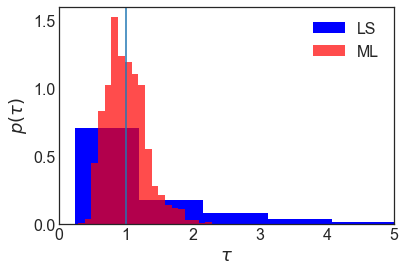

In [49]:
# decay time
plt.figure(facecolor="white")
plt.hist(result_array.T[0],normed=True,bins=30,label="LS",color="blue")
plt.hist(result_Bayes_array.T[2],normed=True,alpha=0.7,bins=20,label="ML",color="red")
plt.axvline(x=1.0)
plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel(r"$p(\tau)$")
plt.xlim((0,5))
plt.savefig("tau_2kdist300.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [38]:
phi = 1/result_array.T[3]
theta = 1/result_array.T[1]
omega = 1/result_array.T[4]
dA = np.sqrt(-theta/(phi*theta-omega**2))
dT = np.sqrt(-phi/(phi*theta-omega**2))*delta_t


In [39]:
print("Decay time LS mean (real):",result_array.T[0].mean())
print("Decay time LS std (real):",result_array.T[0].std())
print("Decay time LS stderr (real):",result_array.T[0].std()/np.sqrt(N))
print("Decay time (mean-true)/stderr:",(result_array.T[0].mean()-1)/result_array.T[0].std()*np.sqrt(N))
print("Decay time LS std (fit):",(np.sqrt(result_array.T[1])*delta_t).mean())
print("Decay time LS std (fit corrected):",dT.mean())
print("Decay time Bayes mean (real):",result_Bayes_array.T[2].mean())
print("Decay time Bayes std (real):",result_Bayes_array.T[2].std())
print("Decay time Bayes stderr (real):",result_Bayes_array.T[2].std()/np.sqrt(N))
print("Decay time Bayes std (fit):",result_Bayes_array.T[3].mean())

Decay time LS mean (real): 1.3587749525271064
Decay time LS std (real): 1.8470844116716065
Decay time LS stderr (real): 0.04130206304677918
Decay time (mean-true)/stderr: 8.68661093565118
Decay time LS std (fit): 0.05215044185979458
Decay time LS std (fit corrected): 0.06275785085502054
Decay time Bayes mean (real): 1.0055027277847248
Decay time Bayes std (real): 0.3003203613051664
Decay time Bayes stderr (real): 0.006715367429056494
Decay time Bayes std (fit): 0.32205769501322445


/Users/hstrey/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


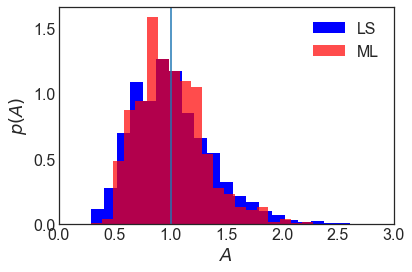

In [40]:
# amplitude
plt.hist(result_array.T[2],normed=True,bins=20,label="LS",color="blue")
plt.hist(result_Bayes_array.T[0],normed=True,alpha=0.7,bins=20,label="ML",color="red")
plt.axvline(x=1.0)
plt.legend()
plt.xlabel(r"$A$")
plt.ylabel(r"$p(A)$")

plt.xlim((0,3))
plt.savefig("A_2kdist300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [41]:
print("Amplitude LS mean (real):",result_array.T[2].mean())
print("Amplitude LS std (real):",result_array.T[2].std())
print("Amplitude LS stderr (real):",result_array.T[2].std()/np.sqrt(N))
print("Amplitude LS std (fit):",np.sqrt(result_array.T[3]).mean())
print("Amplitude LS std (fit corrected):",dA.mean())
print("Amplitude Bayes mean (real):",result_Bayes_array.T[0].mean())
print("Amplitude Bayes std (real):",result_Bayes_array.T[0].std())
print("Amplitude Bayes std (fit):",result_Bayes_array.T[1].mean())

Amplitude LS mean (real): 1.0147488012350934
Amplitude LS std (real): 0.35602047473214293
Amplitude LS stderr (real): 0.007960859828828179
Amplitude LS std (fit): 0.025088932179522065
Amplitude LS std (fit corrected): 0.025166502504945783
Amplitude Bayes mean (real): 1.0061291560273131
Amplitude Bayes std (real): 0.29926383821657704
Amplitude Bayes std (fit): 0.32052861403791433


(1000, 5)
(1000, 4)
(0.2463508260461941, 2.7301653983245087e-15)


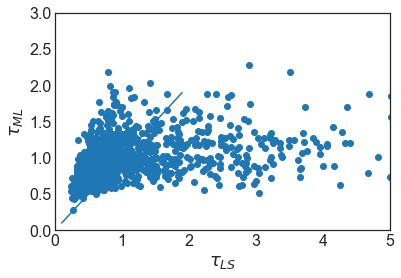

In [42]:
#decay correlation
print(result_array.shape)
print(result_Bayes_array.shape)
plt.scatter(result_array.T[0],result_Bayes_array.T[2])
plt.plot([0.1,1.9],[0.1,1.9])
plt.xlim((0,5))
plt.ylim((0,3))
plt.xlabel(r'$\tau_{LS}$')
plt.ylabel(r'$\tau_{ML}$')
print(pearsonr(result_array.T[0],result_Bayes_array.T[2]))
plt.savefig("tau_2kcorr300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

(0.8593502720211577, 6.316785360739052e-293)


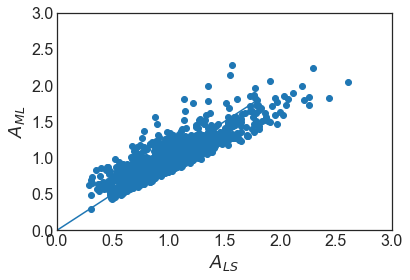

In [43]:
# amplitude correlation
plt.scatter(result_array.T[2],result_Bayes_array.T[0])
plt.plot([0,1.8],[0,1.8])
plt.xlim((0,3))
plt.ylim((0,3))
plt.xlabel(r'$A_{LS}$')
plt.ylabel(r'$A_{ML}$')
print(pearsonr(result_array.T[2],result_Bayes_array.T[0]))
plt.savefig("A_2kcorr300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [44]:
for i,a,da,t,dt in zip(range(len(result_array.T[2])),result_array.T[2],dA,result_array.T[0],dT):
    print(i,a,da,t,dt)

0 0.8542903698574278 0.030111495293485873 0.36940721996841747 0.018661719830536362
1 1.3352927332289166 0.03148354228911341 0.6679271848101643 0.022444482794059497
2 0.809165512001176 0.027117661982865995 0.9141487176719599 0.04359965564741435
3 0.9232714710960248 0.04276949498501148 0.4667956962297879 0.03092209207480228
4 1.4346363370737372 0.08835396570783505 0.42704348000185427 0.0376105713853587
5 1.8646522408194373 0.0588349637482679 0.7698151318882179 0.03456299782541665
6 0.8883799801630683 0.022291058023141495 5.491820028902228 0.34067642834653855
7 1.5446808747938592 0.0573505369790536 0.5571937509244671 0.029523065570190944
8 1.1102934935545203 0.059149946594471724 0.6214316066588007 0.04720990263216429
9 1.5450187984708146 0.021465454952224457 1.9630728870028396 0.0410263633736814
10 1.2740765844199395 0.054169369663976764 0.6859802366328767 0.04156996416482698
11 0.8349952342189852 0.046684344580974 0.3744496260156398 0.03002322063160929
12 1.1648015626858332 0.05668369870

509 1.014966347291514 0.012118583131796225 1.4663490619986927 0.02526324466434786
510 1.0861342476672111 0.039388604211168785 0.6510490762324999 0.03365663406508126
511 0.9323436281474389 0.021984895414270855 1.0405480954819246 0.034928289385793114
512 1.074100360164882 0.027059199486467227 0.7242581134424271 0.025976928884242183
513 0.6312259395262996 0.020450985951746554 1.7911459524039248 0.08578668881691627
514 1.0134068613685567 0.01625459589809048 2.731993542688562 0.07286678934103842
515 0.9089697171105373 0.032519795693048824 0.7253205750367144 0.036966630039142835
516 1.0102541983218143 0.044441318484809846 0.4653333866005607 0.02924506766101068
517 0.6829947279472948 0.021091999397008322 0.4432793659040759 0.019579839262068015
518 1.0001717144905715 0.00794280038090905 1.2203722754758441 0.013842427938972033
519 0.7428637522911472 0.01892858621295056 1.1499218875566637 0.04177349716002487
520 0.660838562273572 0.009668893150481328 0.766310831207682 0.015960033433809806
521 0.

In [45]:
n=113
acf = acf_all[n]
t = np.arange(len(acf))*delta_t
fit = result_array.T[2][n]*np.exp(-t/result_array.T[0][n])
print("{0:.2E}".format(1/np.sqrt(2*np.pi)*np.exp(-(result_array.T[2][n]-1.0)**2/2.0/result_array.T[3][n]**2)))
print(-(result_array.T[2][n]-1.0)**2/2.0/result_array.T[3][n]**2/np.log(10))
print(1/np.sqrt(2*np.pi))
print("{0:.2E}".format(1/np.sqrt(2*np.pi)*np.exp(-(result_array.T[0][n]-1.0)**2/2.0/result_array.T[1][n]**2)))
print(-(result_array.T[0][n]-1.0)**2/2.0/result_array.T[1][n]**2/np.log(10))

0.00E+00
-147034.65357159014
0.3989422804014327
3.98E-01
-0.0006462972011192744


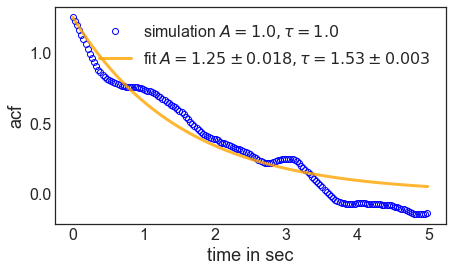

In [48]:
plt.figure(figsize=(7,4))
plt.plot(t[::3],acf[::3],"o",markersize=6,fillstyle="none",markeredgewidth=1,markeredgecolor="blue",label=r"simulation $A=1.0,\tau=1.0$")
plt.plot(t,fit,linewidth=3,color="orange",label=r"fit $A=1.25\pm0.018,\tau=1.53\pm0.003$",alpha=0.8)
plt.xlabel("time in sec")
plt.ylabel("acf")
plt.legend()
plt.savefig("exp_2kfit300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [47]:
print(plt.style.available)

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']
